## Evaluación de rendimiento de clasificación SIAF

* Fecha: 2024-04-01
* Coder: Lenin Gonzalo Falconí, M.Sc.
* Objetivos:

    - Medir con métricas de clasificación el rendimiento de las etiquetas de desagregación SIAF

## Metodología

1. Se lee los datos de DaaS.robosML_predicted_tmp que contiene resultados de la ejecución del modelo y otras tareas ETL, donde existe información de la comisión interinstitucional
2. Se eliminan registros cuyas categorías no pertenezcan a las 6 de **delitos seguimiento** y la categoría otros robos
3. Se eliminan registros donde la comisión apunta **SIN INFORMACION**
4. Se ejecutan las métricas de rendimiento de clasificadores, considerando que el problema que resuelve el funcionario digitador es un problema de clasificación en donde a partir de un texto tokenizable obtiene $k=6$ categorías


## Lectura de datos
A la fecha de ejecución son '733272' registros donde $\exists$ ndds no nulas dela comisión

In [1]:
import pandas as pd
from src.utils import conectar_sql
query = """select robos.NDD,
                robos.DELITO_DESAGREGACION_SEGUIMIENTO as 'desagregacionSiaf',
                robos.delitos_seguimiento_comision as 'desagregacionComision'
                from DaaS.robosML_predicted_tmp robos 
                where robos.delitos_seguimiento_comision is not null;"""

conx = conectar_sql()

dataset = pd.read_sql(query, conx)
dataset.shape

conectando con big data database....


(733272, 3)

Se observan categorías en SIAF distintas a las 6 de delitos seguimiento. Esto es natural ya que el digitador siaf puede ingresar el dato manualmente y también la Comisión suele aplicar el Sin Información para categorías que se salen de las 6. Por esta razón se eliminan para la comparación

In [3]:
dataset.desagregacionSiaf.value_counts()

ROBO A PERSONAS                                         299553
ROBO A DOMICILIO                                        145071
OTROS ROBOS                                              68877
ROBO DE MOTOS                                            63262
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS     50816
ROBO DE CARROS                                           45267
ROBO A UNIDADES ECONOMICAS                               22390
ROBO DE ACCESORIOS DE VEHICULOS                          19301
ROBO DE VEHICULOS                                        11978
ROBO EN VIAS O CARRETERAS                                 2170
ROBO DE BIENES PERSONALES AL INTERIOR DEL VEHICULO        1968
REVIEW_LABEL                                              1946
ROBO DE BIENES A ENTIDAD PUBLICA                           673
Name: desagregacionSiaf, dtype: int64

La Comisión por su parte tiene las categorías siguientes

In [4]:
set(dataset.desagregacionComision)

{'ROBO A DOMICILIO',
 'ROBO A PERSONAS',
 'ROBO A UNIDADES ECONOMICAS',
 'ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS',
 'ROBO DE CARROS',
 'ROBO DE MOTOS',
 'SIN INFORMACION'}

No existen nulos en el dataset

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733272 entries, 0 to 733271
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   NDD                    733272 non-null  object
 1   desagregacionSiaf      733272 non-null  object
 2   desagregacionComision  733272 non-null  object
dtypes: object(3)
memory usage: 16.8+ MB


## Proceso de ETL o limpieza del dataset

Ejecutando la elimnación de categorias no necesarias

In [12]:
dataset_cl = dataset.copy()
dataset_cl = dataset_cl[dataset_cl.desagregacionComision!="SIN INFORMACION"]
categorias_comparables = list(set(dataset_cl.desagregacionComision))
categorias_comparables

['ROBO A UNIDADES ECONOMICAS',
 'ROBO A DOMICILIO',
 'ROBO DE CARROS',
 'ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS',
 'ROBO DE MOTOS',
 'ROBO A PERSONAS']

In [13]:
dataset_cl = dataset_cl[dataset_cl.desagregacionSiaf.isin(categorias_comparables)]
dataset_cl.desagregacionSiaf.value_counts()

ROBO A PERSONAS                                         280843
ROBO A DOMICILIO                                        126979
ROBO DE MOTOS                                            61210
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS     49361
ROBO DE CARROS                                           43403
ROBO A UNIDADES ECONOMICAS                               18819
Name: desagregacionSiaf, dtype: int64

In [14]:
dataset_cl.shape[0]/dataset.shape[0]*100

79.18139517123251

In [15]:
dataset.shape, dataset_cl.shape

((733272, 3), (580615, 3))

Se utilizan 79% de los datos originales

## Medición de Clasificación

In [16]:
from sklearn.metrics import classification_report
y_true = dataset_cl.desagregacionComision.to_list()
y_predict = dataset_cl.desagregacionSiaf.to_list()

print(classification_report(y_true=y_true, y_pred=y_predict, labels=categorias_comparables))

                                                      precision    recall  f1-score   support

                          ROBO A UNIDADES ECONOMICAS       0.85      0.42      0.57     37834
                                    ROBO A DOMICILIO       0.85      0.96      0.90    112972
                                      ROBO DE CARROS       0.91      0.90      0.90     43858
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS       0.96      0.74      0.83     64552
                                       ROBO DE MOTOS       0.98      0.88      0.93     68615
                                     ROBO A PERSONAS       0.87      0.97      0.92    252784

                                            accuracy                           0.89    580615
                                           macro avg       0.91      0.81      0.84    580615
                                        weighted avg       0.89      0.89      0.88    580615



La $accuracy$ global está en 89%. Se debe observar que el modelo tiene un rendimiento del 92% en seguimiento y 95% en validados. Dado que no se conoce los resultados y la metodología empleada por la Comisión para indicar si la desagregación escrita en SIAF tiene un nivel de error, estos resultados son un punto de partida. Según conversaciones, recuerdo que estiman que el error SIAF, por así decirlo, estaría en un 20%. Sin embargo, si consideramos al error como el complemento del resultado obtenido, la métrica sería 11%. 

El resultado con $f_1score$ más bajo corresponde a Robo a Unidades Económicas

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=y_true, y_pred=y_predict, normalize='true', labels=categorias_comparables)

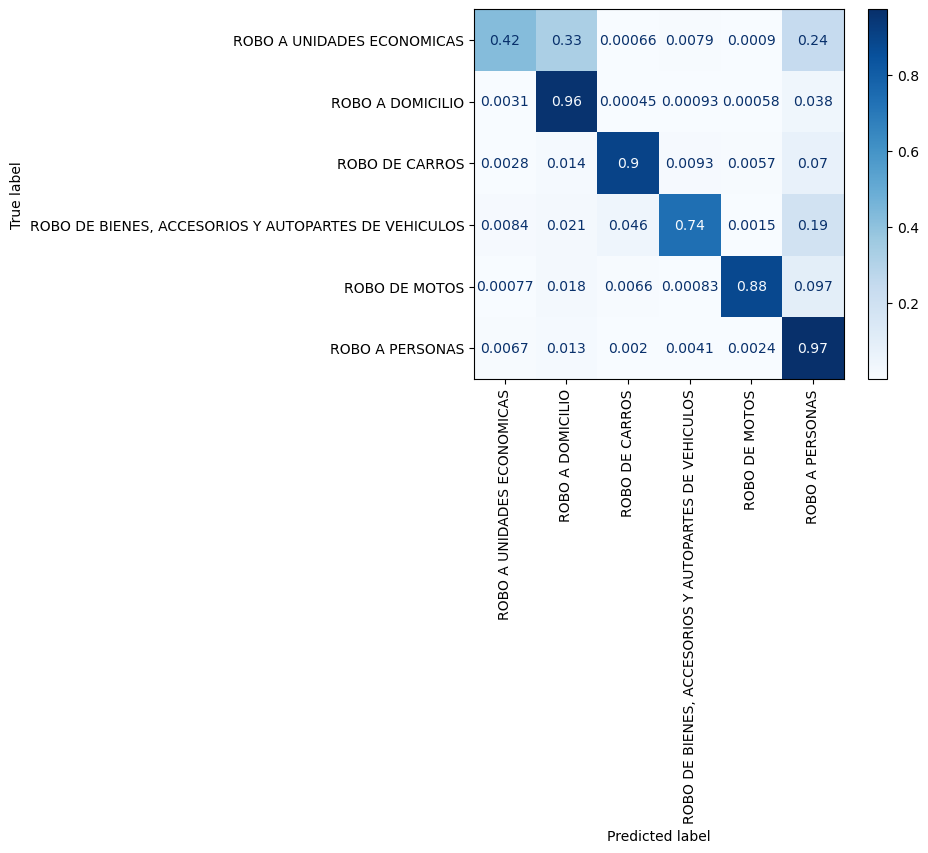

In [35]:
import matplotlib.pyplot as plt

cm_disp = ConfusionMatrixDisplay(cm, display_labels=categorias_comparables)
cm_disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()

In [38]:
cm_all = confusion_matrix(y_true=y_true, y_pred=y_predict, normalize=None, labels=categorias_comparables)

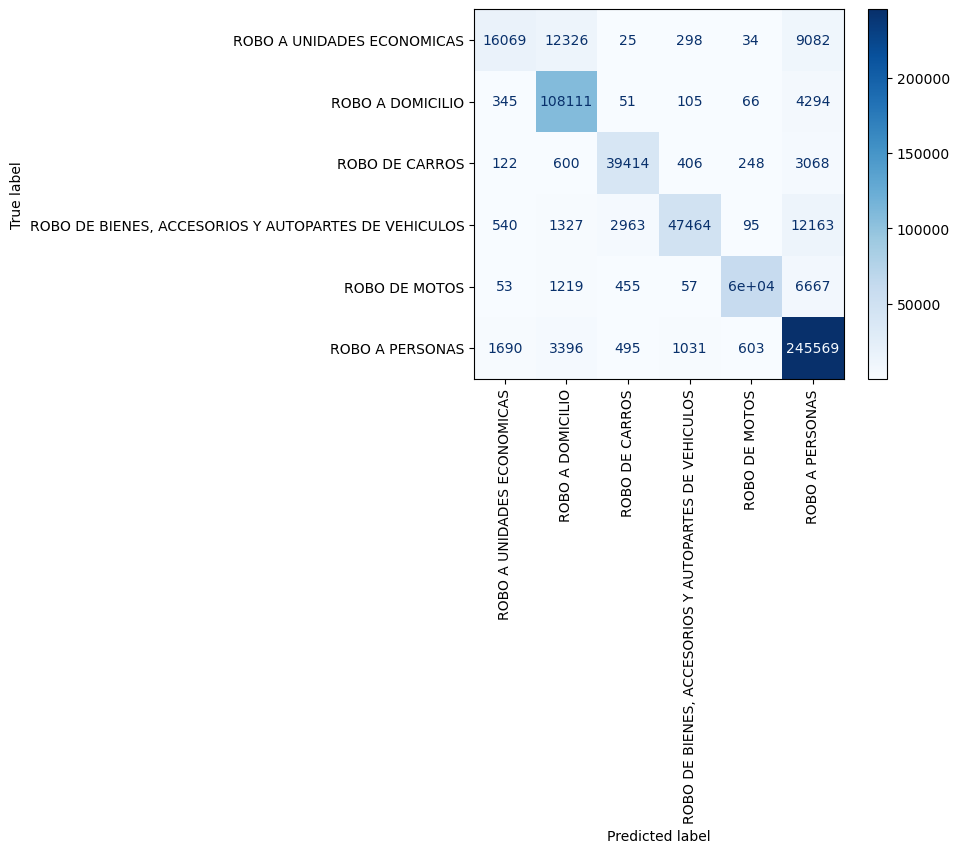

In [39]:
cm_all_disp = ConfusionMatrixDisplay(cm_all, display_labels=categorias_comparables)
cm_all_disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()

## Conclusiones

1. Se observa que la tasa de error, entendida como el complemento del desempeño es del 11%.
2. La matriz de confusión normalizada con respecto a los valores de la comisión indica 4 focos de confusión en las etiquetas, que se puede sugerir debería ser resuelta en una mesa que integre funcionarios SAI y los de Comisión a fin de resolver la discrepancia en la clasificación.
3. En todos los casos se ha calculado la matriz de confusión normalizada con respecto al conjunto de datos que asumimos de etiquetación correcta i.e. comisión interinstitucional.
4. Se observa que el ingreso de datos por Fiscalía varía en función de la digitación. Sin embargo, semánticamente se podría hacer coincidir con uno de los tipos antes definidos.
5. Los resultados sugieren que en algún momento puede ser requerido el ajuste del modelo.